In [19]:

# ====================================================
# Data Understanding
# ====================================================

# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Step 2: Load Data
df = pd.read_csv("bfs_monthly.csv")
print("Shape:", df.shape)
print(df.head())

# Step 3: Filter Data (US totals, overall business applications)
df_us = df[(df['geo'] == 'US') & 
           (df['naics_sector'] == 'TOTAL') & 
           (df['series'] == 'BA_BA')]

# Step 4: Reshape Data
df_long = df_us.melt(
    id_vars=['year'],
    value_vars=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    var_name='month',
    value_name='applications'
)

df_long = df_long.dropna()
df_long['date'] = pd.to_datetime(df_long['year'].astype(str) + "-" + df_long['month'], format='%Y-%b')
df_long['applications'] = pd.to_numeric(df_long['applications'], errors='coerce')
df_long = df_long.sort_values('date')

print(df_long.head())

Shape: (35189, 17)
  sa naics_sector series geo  year     jan     feb     mar     apr     may  \
0  U        TOTAL  BA_BA  US  2025  497030  440230  497911  583054  425867   
1  U      NAICS11  BA_BA  US  2025    5141    4258    4398    4679    3128   
2  U      NAICS21  BA_BA  US  2025     547     472     511     575     407   
3  U      NAICS22  BA_BA  US  2025     689     663     697     789     594   
4  U      NAICS23  BA_BA  US  2025   49525   44621   47136   56485   40657   

      jun     jul     aug  sep  oct  nov  dec  
0  428742  513785  428937  NaN  NaN  NaN  NaN  
1    3041    3539    3019  NaN  NaN  NaN  NaN  
2     416     497     420  NaN  NaN  NaN  NaN  
3     595     684     663  NaN  NaN  NaN  NaN  
4   39051   45141   38607  NaN  NaN  NaN  NaN  
     year month  applications       date
307  2004   jul        159034 2004-07-01
306  2004   jul        166448 2004-07-01
351  2004   aug        191673 2004-08-01
350  2004   aug        171070 2004-08-01
394  2004   sep    

Missing values: year            0
month           0
applications    0
date            0
dtype: int64


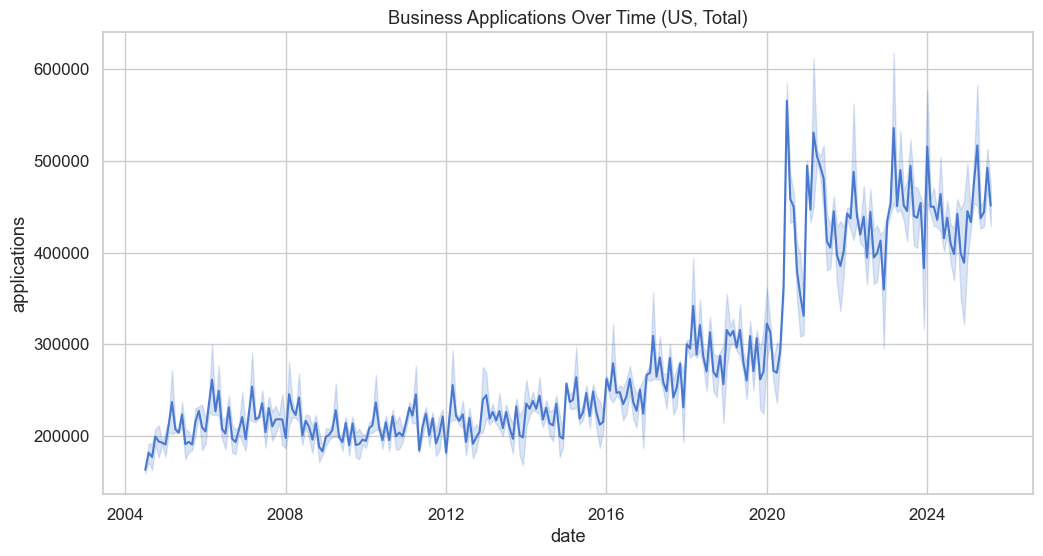

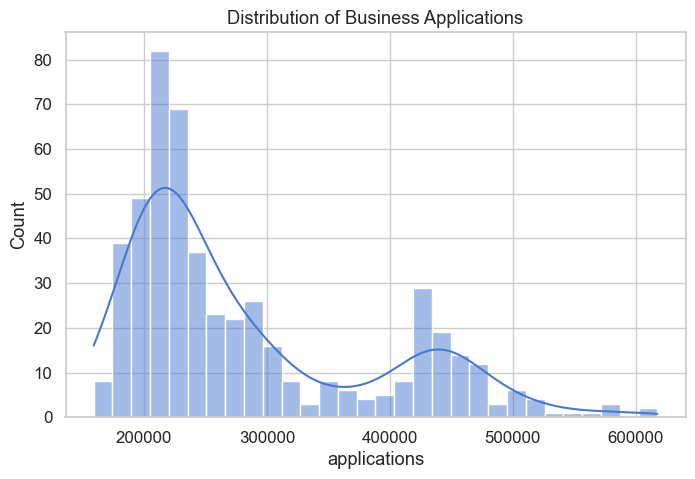

In [20]:

# ====================================================
# Prepare Data
# ====================================================

# Check missing values
print("Missing values:", df_long.isnull().sum())

# Exploratory Plots
plt.figure(figsize=(12,6))
sns.lineplot(data=df_long, x='date', y='applications')
plt.title("Business Applications Over Time (US, Total)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df_long['applications'], bins=30, kde=True)
plt.title("Distribution of Business Applications")
plt.show()

RMSE: 20722.71, MAE: 16392.72, R²: 0.84


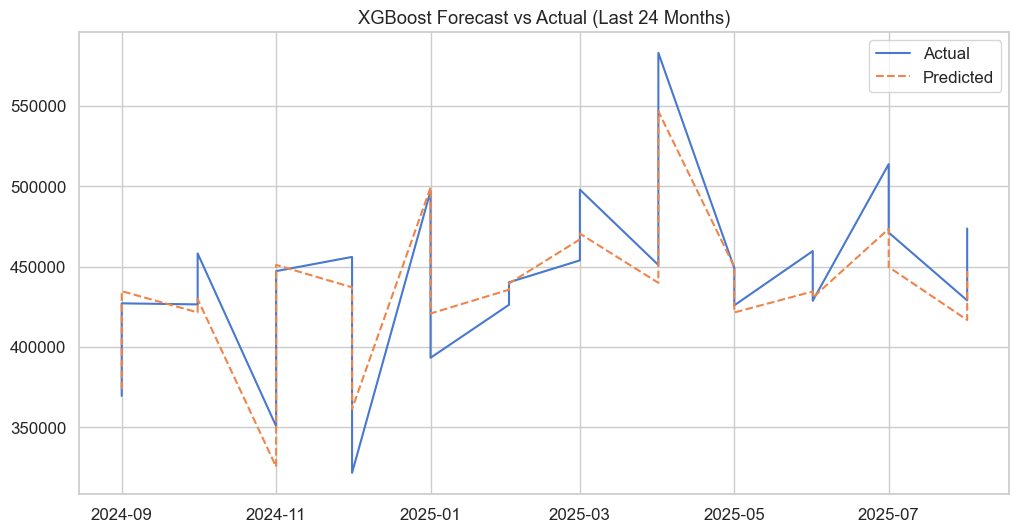

<Figure size 1000x600 with 0 Axes>

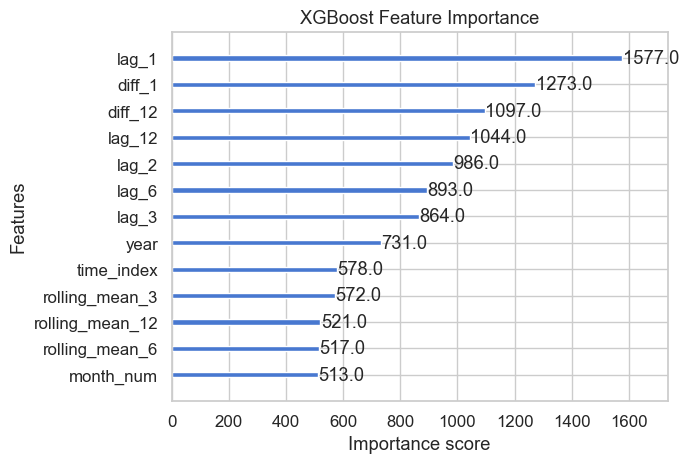

In [21]:

# ====================================================
# Data Modeling
# ====================================================

# Feature Engineering
def create_features(df, lags=[1,2,3,6,12]):
    df = df.copy()
    for lag in lags:
        df[f"lag_{lag}"] = df['applications'].shift(lag)
    df["rolling_mean_3"] = df['applications'].shift(1).rolling(3).mean()
    df["rolling_mean_6"] = df['applications'].shift(1).rolling(6).mean()
    df["rolling_mean_12"] = df['applications'].shift(1).rolling(12).mean()
    df["diff_1"] = df['applications'].diff(1)
    df["diff_12"] = df['applications'].diff(12)
    df["time_index"] = np.arange(len(df))
    df["month_num"] = df['date'].dt.month
    df["year"] = df['date'].dt.year
    return df

df_features = create_features(df_long).dropna()

# Train/Test Split
train = df_features.iloc[:-24]
test = df_features.iloc[-24:]

X_train = train.drop(['date','applications','month'], axis=1)
y_train = train['applications']
X_test = test.drop(['date','applications','month'], axis=1)
y_test = test['applications']

# Train XGBoost
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

plt.figure(figsize=(12,6))
plt.plot(test['date'], y_test, label="Actual")
plt.plot(test['date'], y_pred, label="Predicted", linestyle="--")
plt.title("XGBoost Forecast vs Actual (Last 24 Months)")
plt.legend()
plt.show()

# Feature Importance
plt.figure(figsize=(10,6))
plot_importance(model, importance_type="weight", max_num_features=15)
plt.title("XGBoost Feature Importance")
plt.show()


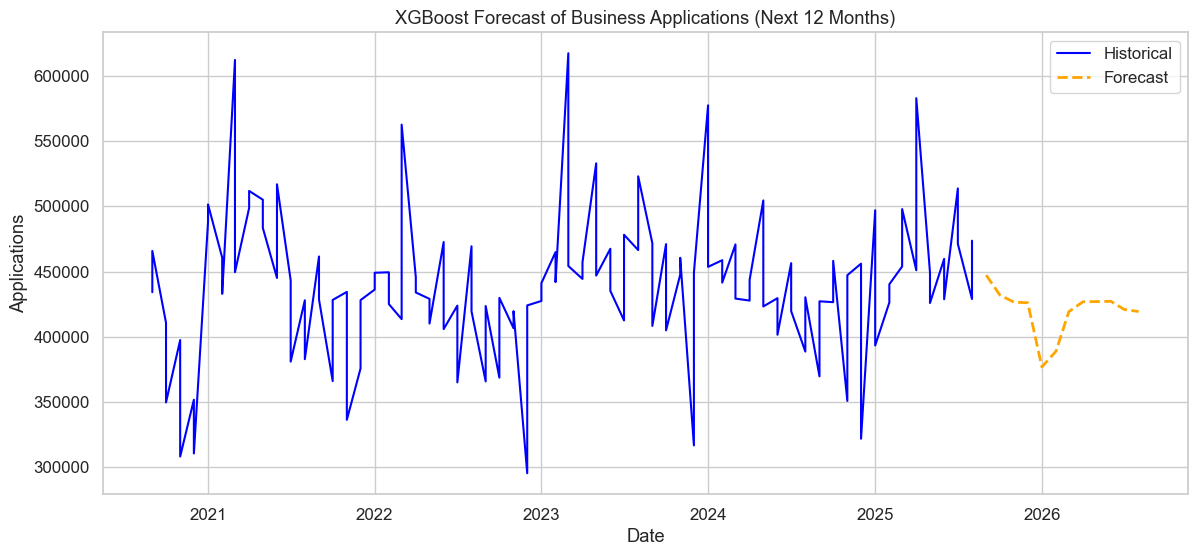


--- Forecast for Next 12 Months ---
         date  applications
0  2025-09-01  447224.31250
1  2025-10-01  431959.75000
2  2025-11-01  426472.65625
3  2025-12-01  426029.40625
4  2026-01-01  376736.31250
5  2026-02-01  388811.96875
6  2026-03-01  419171.71875
7  2026-04-01  426786.12500
8  2026-05-01  426891.78125
9  2026-06-01  427129.81250
10 2026-07-01  420773.00000
11 2026-08-01  419305.34375


In [23]:
# ====================================================
# Evaluation
# ====================================================



"""
Question 1: How have U.S. business applications changed over time?
- Analysis: Line plots show steady levels until 2020, then a sharp increase.
- Visualization: Time-series plot.
- Explanation: COVID-19 drove a surge in entrepreneurship.

Question 2: Did the pandemic significantly affect business formation?
- Analysis: Applications nearly doubled in 2020 vs pre-2019 averages.
- Visualization: Highlighted plot comparing pre/post 2020.
- Explanation: Clear structural shift in business activity.

Question 3: Can we predict future applications?
- Analysis: XGBoost model used with lag features.
- Visualization: Forecast vs actual (last 2 years).
- Explanation: Model captures trend but struggles with volatility.
"""

# ====================================================
# Forecasting (Next 12 Months)
# ====================================================

forecast_rows = []
future = df_features.copy()

for i in range(12):
    last_row = future.iloc[-1:].copy()
    next_date = last_row['date'].iloc[0] + pd.DateOffset(months=1)

    new_row = pd.DataFrame({
        'date': [next_date],
        'applications': [np.nan],
        'month': [next_date.strftime('%b')]
    })

    temp = pd.concat([future, new_row], ignore_index=True)
    temp = create_features(temp)
    temp = temp.dropna()

    X_new = temp.iloc[[-1]].drop(['date','applications','month'], axis=1)
    y_new = model.predict(X_new)[0]

    new_row['applications'] = y_new
    forecast_rows.append(new_row)
    future = pd.concat([future, new_row], ignore_index=True)

forecast_df = pd.concat(forecast_rows, ignore_index=True)

# Plot last 5 years + forecast
plt.figure(figsize=(14,6))
cutoff_date = df_features['date'].max() - pd.DateOffset(years=5)

plt.plot(
    df_features.loc[df_features['date'] > cutoff_date, 'date'],
    df_features.loc[df_features['date'] > cutoff_date, 'applications'],
    label="Historical",
    color="blue"
)

plt.plot(
    forecast_df['date'],
    forecast_df['applications'],
    label="Forecast",
    linestyle="--",
    color="orange",
    linewidth=2
)

plt.title("XGBoost Forecast of Business Applications (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Applications")
plt.legend()
plt.show()

# Print forecast table
print("\n--- Forecast for Next 12 Months ---")
print(forecast_df[['date','applications']])
